In [1]:
##### %pylab inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.warnings.filterwarnings('ignore')
import datetime
import os
import math
import time
import torch
import gpytorch

import excursion

import excursion.testcases.fast_1D as testcase_details
import excursion.optimize
import excursion.active_learning as active_learning

from excursion.utils import get_first_max_index,point_entropy, mesh2points, points2mesh, values2mesh

import excursion.plotting.onedim as plots
#import excursion.utils as utils

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# 0) Init
True frunctions, grid, training data

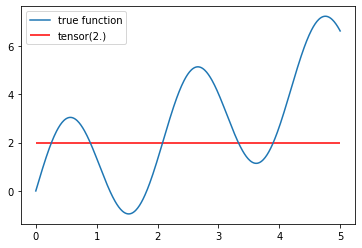

In [3]:
#init true functions + thresholds
for func in testcase_details.true_functions:
    X_plot = testcase_details.plot_X
    plt.plot(X_plot, func(X_plot), label='true function')
    
for thr in testcase_details.thresholds:
    min_X = torch.min(testcase_details.plot_X)
    max_X = torch.max(testcase_details.plot_X)
    plt.hlines(thr, min_X, max_X, colors = 'red', label=str(thr))

plt.legend(loc=0 )

In [4]:
#init data

#init grid
X_grid = testcase_details.X
print('X_grid ', X_grid.shape)

#init training data
# you can do it random if you want
epsilon = testcase_details.epsilon
X_train = torch.Tensor([3.])
noise  = torch.from_numpy(epsilon * np.random.multivariate_normal(np.zeros(1), np.eye(1)))
y_train = testcase_details.true_functions[0](X_train) + noise
y_train = y_train.float()

print('X_0 = ', X_train, X_train.shape)
print('f(X_0) = ', y_train, y_train.shape)

X_grid  torch.Size([500, 1])
X_0 =  tensor([3.]) torch.Size([1])
f(X_0) =  tensor([4.0303]) torch.Size([1])


# 1) GP model selection
To choose between ExactGP or GridRegression + Exact GP
Choose prior

In [5]:
# simplest form of GP model RBF with constant mean prior, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(\
                            gpytorch.kernels.RBFKernel(\
                            lengthscale_constraint=gpytorch.constraints.GreaterThan(lower_bound=0.1)
                            ))
                                                      

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 2) Likelihood selection

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=torch.tensor([epsilon])) 

# 3) Fit model with training points

In [7]:
model = ExactGPModel(X_train, y_train, likelihood)

In [8]:
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

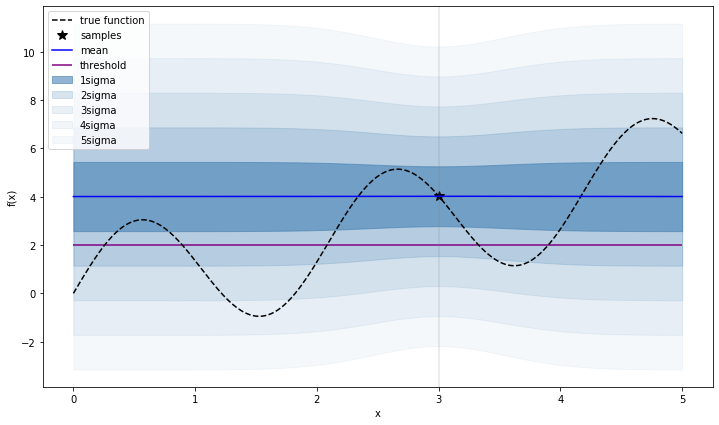

In [9]:
plots.plot_GP(model, testcase_details);
plt.savefig('1D_images/1D_'+str(0)+'_sin_'+str('MES')+'.png')

# 4) acquisition function selection

In [10]:
#init active learning method
acq_type = testcase_details.acq_type

# 5) Smart grid seach (active learning)

I didnt get an axis
Iteration 0, x_new tensor([[0.]]) 

I didnt get an axis
Iteration 1, x_new tensor([[1.3226]]) 

I didnt get an axis
Iteration 2, x_new tensor([[3.2265]]) 

I didnt get an axis
Iteration 3, x_new tensor([[3.6273]]) 

I didnt get an axis
Iteration 4, x_new tensor([[3.3968]]) 

I didnt get an axis
Iteration 5, x_new tensor([[2.1844]]) 

I didnt get an axis
Iteration 6, x_new tensor([[2.0240]]) 

I didnt get an axis
Iteration 7, x_new tensor([[2.0842]]) 

I didnt get an axis
Iteration 8, x_new tensor([[4.3888]]) 

I didnt get an axis
Iteration 9, x_new tensor([[3.8778]]) 

I didnt get an axis
Iteration 10, x_new tensor([[3.3267]]) 

I didnt get an axis
Iteration 11, x_new tensor([[3.8978]]) 

I didnt get an axis
Iteration 12, x_new tensor([[0.6513]]) 

I didnt get an axis
Iteration 13, x_new tensor([[0.3607]]) 

I didnt get an axis
Iteration 14, x_new tensor([[0.8717]]) 

I didnt get an axis
Iteration 15, x_new tensor([[0.2605]]) 

I didnt get an axis
Iteration 16, x_ne

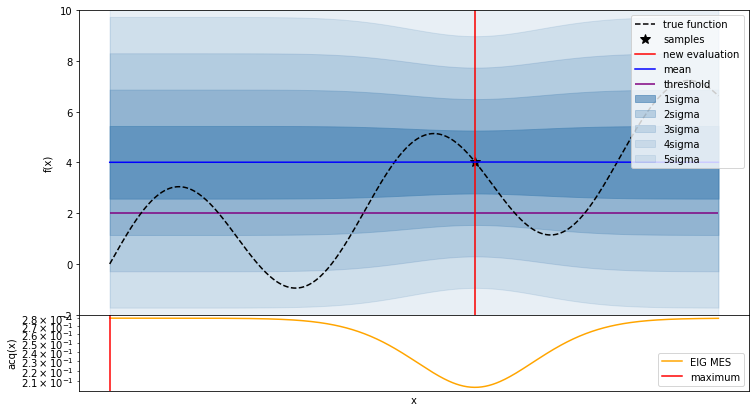

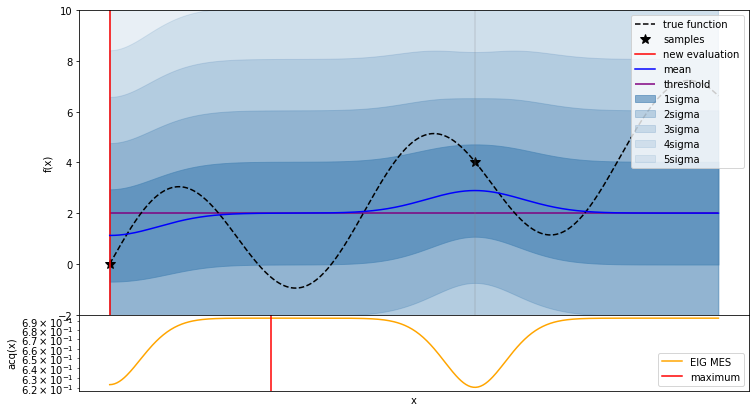

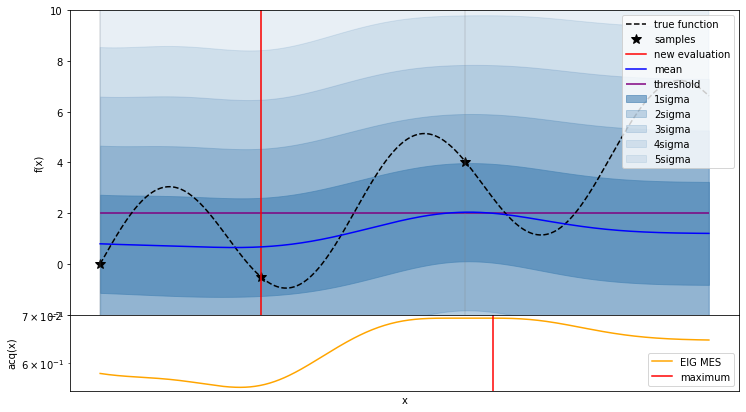

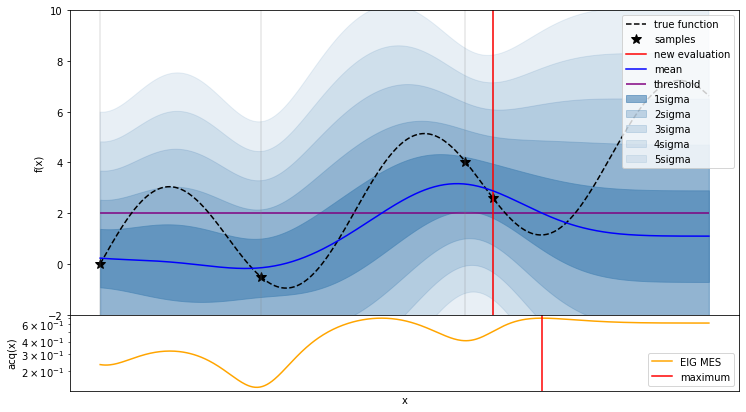

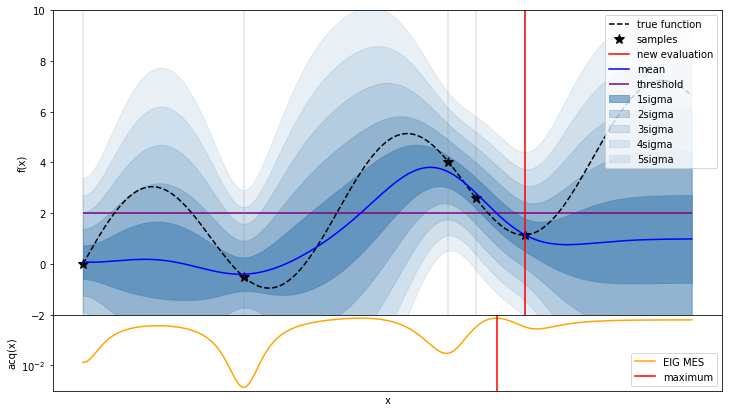

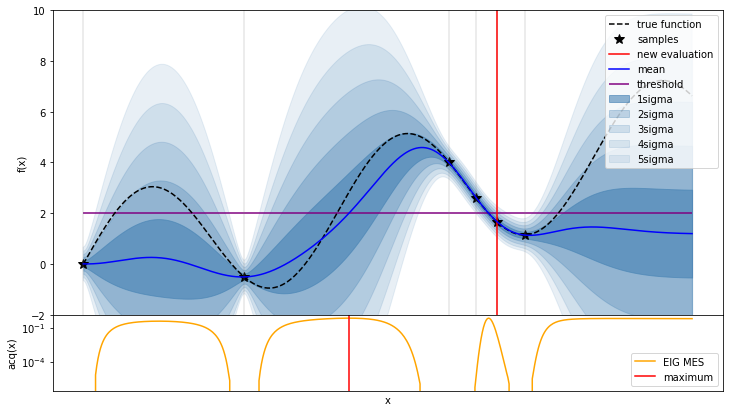

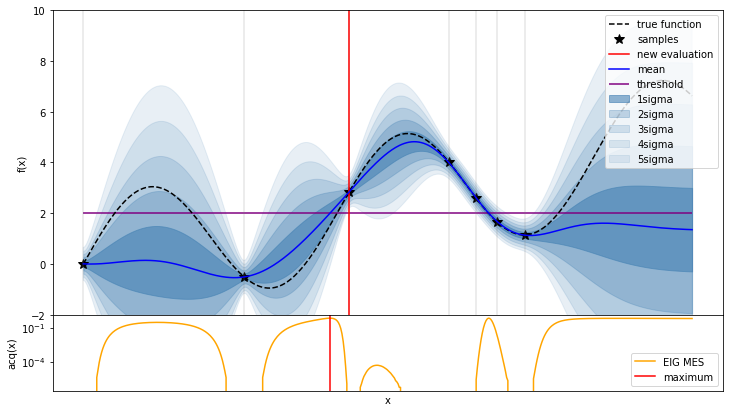

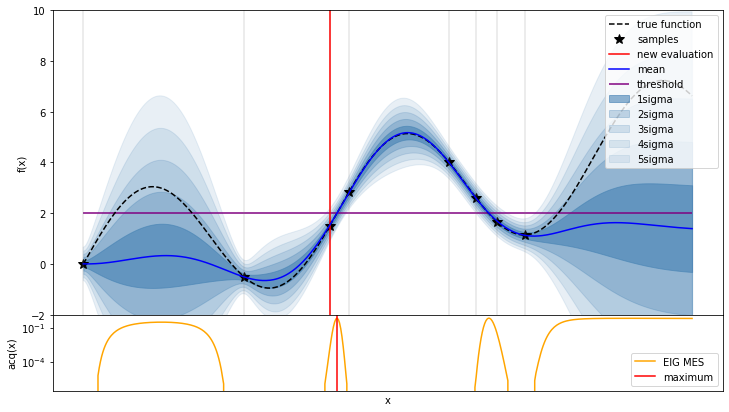

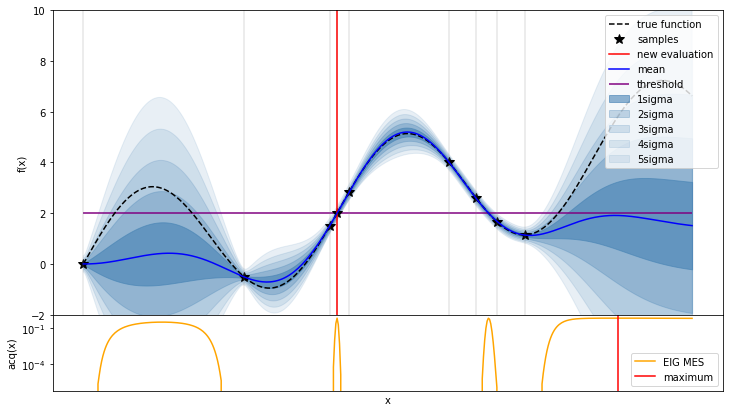

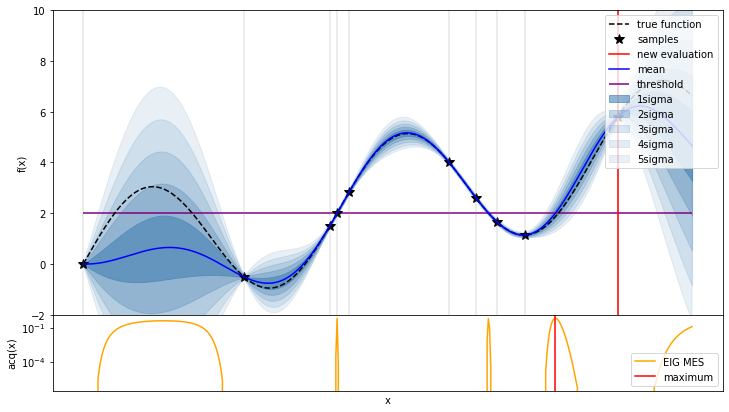

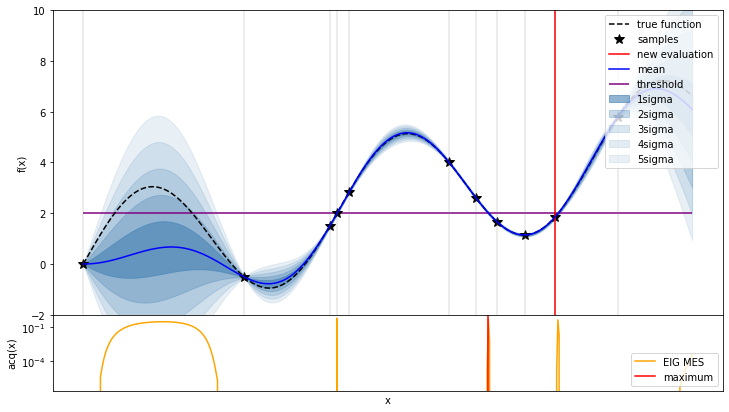

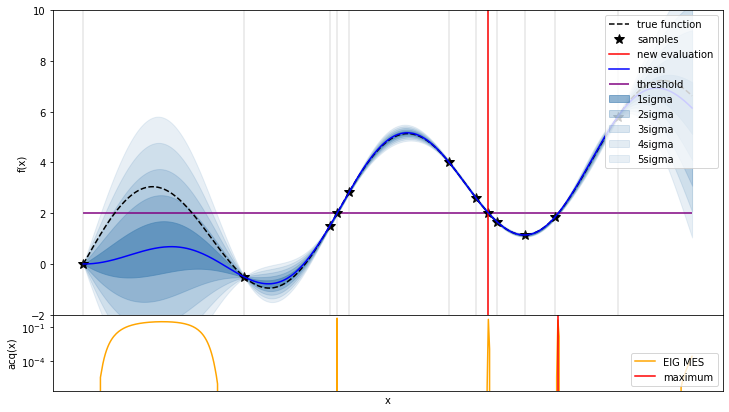

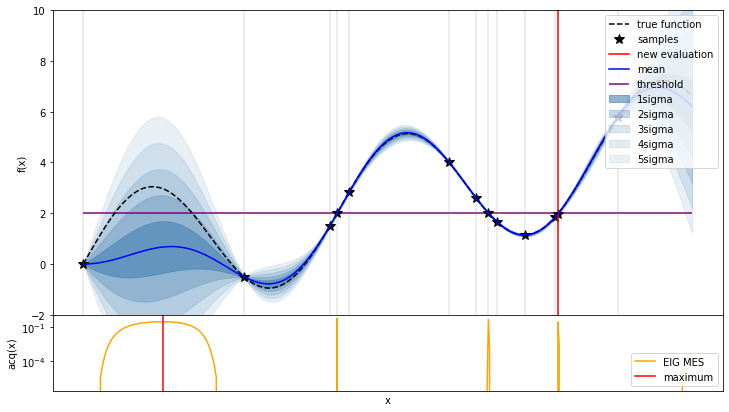

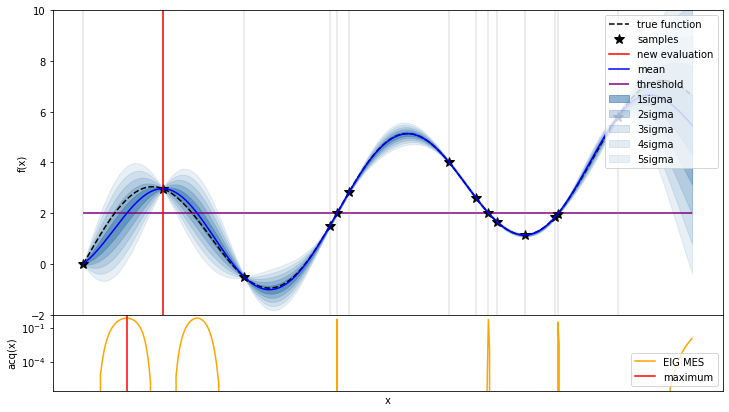

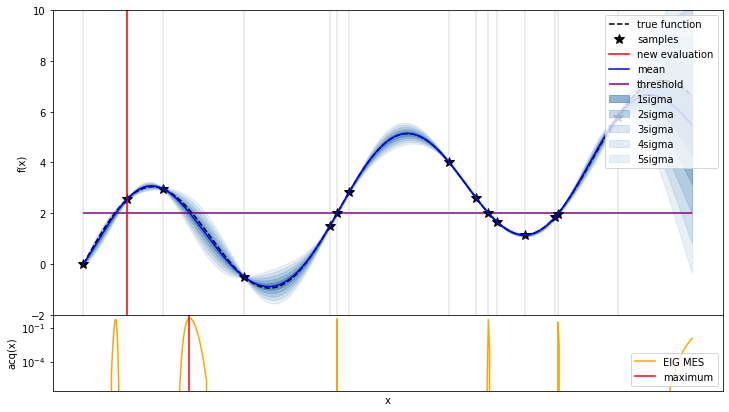

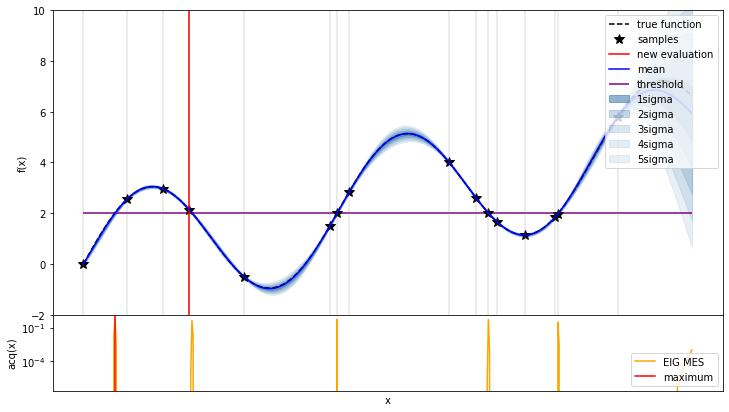

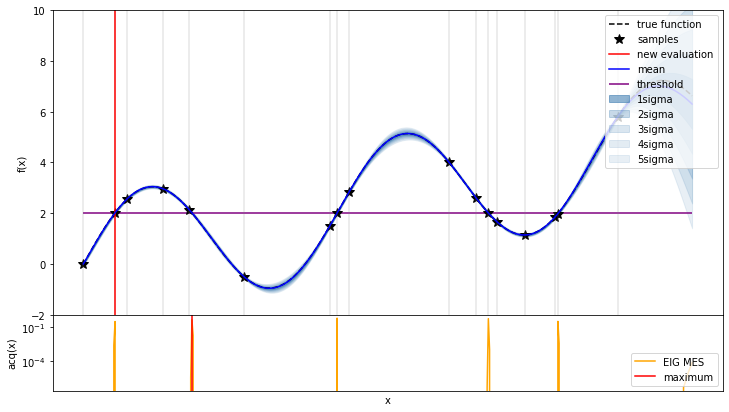

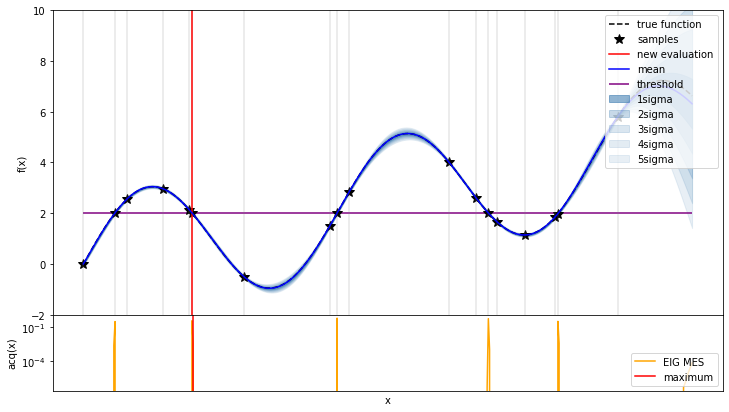

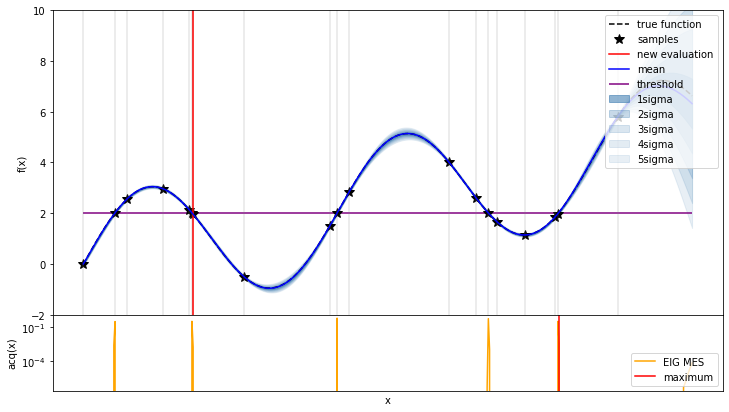

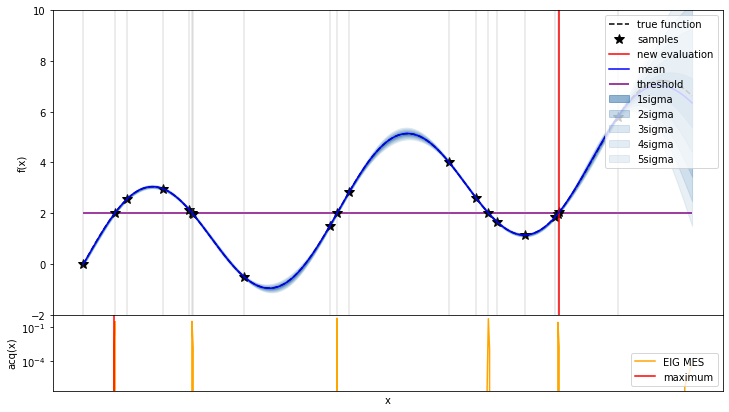

In [11]:
n_iter = 20

acquisition_values_grid = []
for x in X_grid:
    value = active_learning.acq(model,testcase_details, x.view(-1,1), acq_type)
    acquisition_values_grid.append(value)

param = []   

for i in range(n_iter):
    #start = time.process_time()
    
    #find x_new by maximizing acq)(x)
    acquisition_values_grid = []
    for x in X_grid:
        value = active_learning.acq(model,testcase_details, x.view(-1,1), acq_type)
        acquisition_values_grid.append(value)
    new_indexs = np.argsort(acquisition_values_grid)[::-1] #descending order
            
    ##discard those points already in dataset
    new_index = get_first_max_index(model, new_indexs, testcase_details)
    
    ##get x, y
    x_new = testcase_details.X[new_index].view(-1,1)
    noise_new  = torch.from_numpy(epsilon * np.random.normal(0.,1.,1))
    y_new = testcase_details.true_functions[0](x_new) + noise_new
    y_new = y_new.float()
    #print('TIME TAKEN**', time.process_time() - start)    

    #plot and print
    plots.plot_GP(model, testcase_details, acq=acquisition_values_grid, acq_type=acq_type, x_new=x_new ) 
    #plt.savefig('1D_images/1D_'+str(i)+'_noisesmall_'+str(acq_type)+'.png')
    
    #update dataset
    inputs_i = torch.cat((model.train_inputs[0], x_new),0).flatten()
    targets_i = torch.cat((model.train_targets.view(-1,1), y_new),0).flatten()
    model.set_train_data(inputs=inputs_i, targets=targets_i, strict=False)
    model = ExactGPModel(inputs_i, targets_i, likelihood)

    #fit posterior with new dataset
    model.train()
    likelihood.train()
    excursion.fit_hyperparams(model,likelihood)
    
    param.append([model.covar_module.outputscale, model.covar_module.base_kernel.lengthscale])
    
    print('Iteration {}, x_new {} \n'.format(i,x_new))
    

outputscale lengthscale


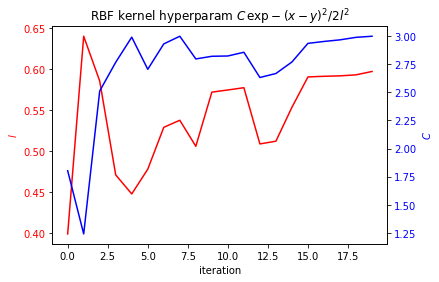

In [12]:
print('outputscale', 'lengthscale')
scale = []
l = []
for i in range(len(param)):
    scale.append(param[i][0].tolist())
    l.append(param[i][1][0][0].tolist())
#   print(i, param[i][0].tolist(), param[i][1][0][0].tolist())

plt.title('RBF kernel hyperparam $C \, \exp -(x-y)^2 / 2l^2$')
plt.xlabel('iteration')
plt.plot(range(len(param)), l, label='$l$', color='red')
plt.tick_params(axis="y", labelcolor="r")
plt.ylabel('$l$', color='red')
plt.twinx()
plt.plot(range(len(param)), scale, label='$C$', color='blue')
plt.tick_params(axis="y", labelcolor="blue")
plt.ylabel('$C$', color='blue')
plt.savefig('1D_images/hyperparameter_PES.png')